In [32]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.sampling import *
from lib.geometry import *
from lib.plotting import *


# Global parameters

In [47]:
# How many radar scans to simulate
n_scans = 1000
n_points_per_scan = 15

# Ground-truth velocity distribution
v_sampling_config = {
    "vx": {"distribution": "uniform", "params": {}, "bounds": (-2, 2)},
    "vy": {"distribution": "uniform", "params": {}, "bounds": (-0.5, 0.5)},
    "vz": {"distribution": "uniform", "params": {}, "bounds": (-0.5, 0.5)},
}

# Sampling (continuous) Radar datapoints

We use a special convention for definition of azimuth, elevation and range, which differs from typical spherical coordinate systems.

For a given regular RHS cartesian coordinate system;
- Y-Axis: perpendicular out of sensor plane
- Z-X-Plane: sensor plane

From this the angles are defined as:
- elevation: angle to Y-X Plane
- azimuth: angle to Z-Y Plane

The convention can be taken from the following image, where 'East', 'North', 'Up' represent X, Y, Z axis respectively.


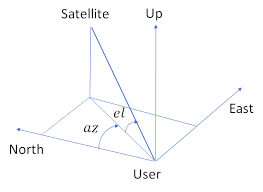


Going forward this is called the **TI-Convention**.

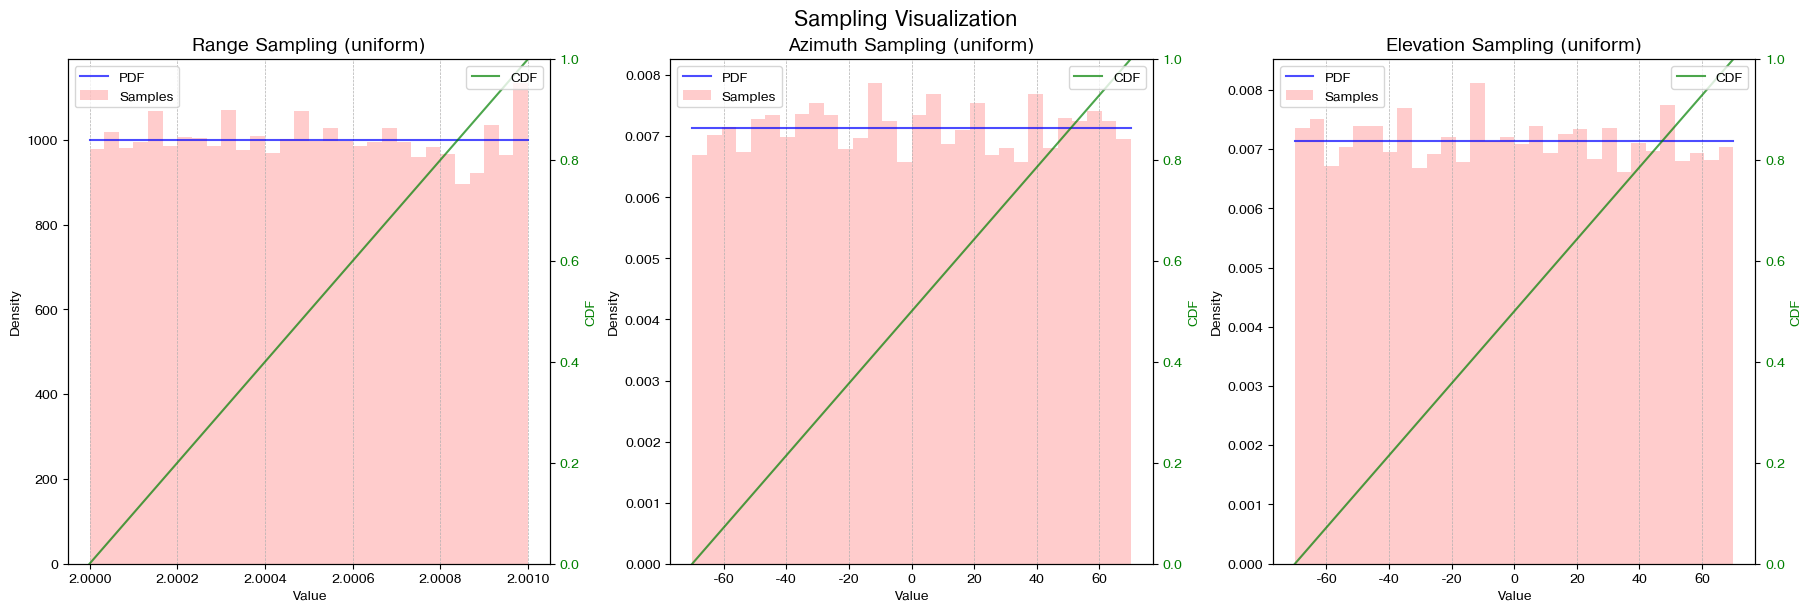

In [48]:
# Example Usage
radar_sampling_config = {
    # "range": {"distribution": "cauchy", "params": {"loc": 7, "scale": 5}, "bounds": (1, 25)},
    # "azimuth": {"distribution": "gaussian", "params": {"mean": 0, "std_dev": 80}, "bounds": (-70, 70)},
    # "elevation": {"distribution": "beta", "params": {"alpha": 0.6, "beta": 0.7}, "bounds": (-70, 70)},
    "range": {"distribution": "uniform", "params": {}, "bounds": (2, 2.001)},
    "azimuth": {"distribution": "uniform", "params": {}, "bounds": (-70, 70)},
    "elevation": {"distribution": "uniform", "params": {}, "bounds": (-70, 70)},
}

# Initialize the sampler
radar_sampler = MultiDimensionalSampler(radar_sampling_config)

radar_sampler.sample(num_samples=n_scans*n_points_per_scan) # np.array with columns [azimuth, elevation, range]

# Generate and visualize samples
radar_sampler.visualize_sampling()

radar_samples = radar_sampler.get_samples()

## Sample ground truth velocities (randomly)

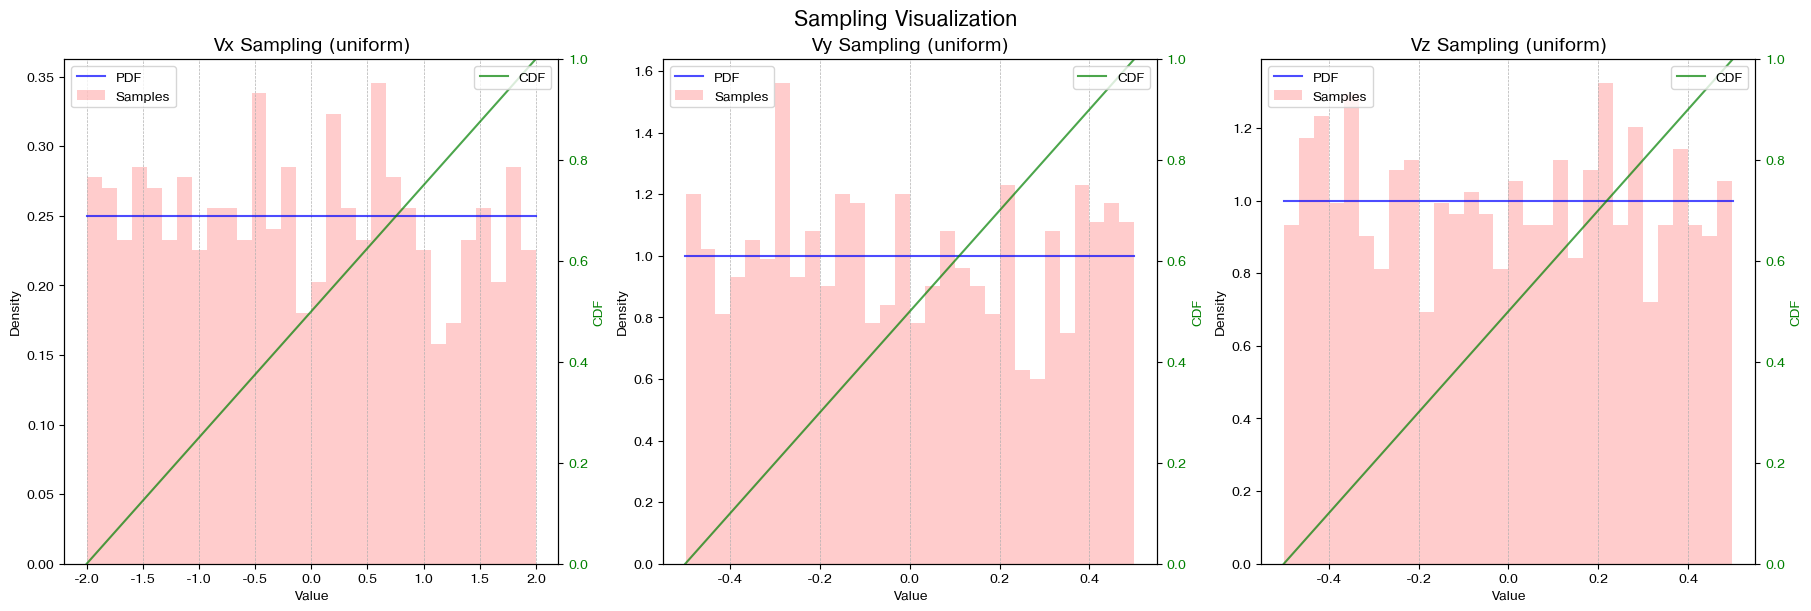

In [49]:
v_sampler = MultiDimensionalSampler(v_sampling_config)
v_sampler.sample(num_samples=n_scans)

v_sampler.visualize_sampling()

velocity_gt_samples = v_sampler.get_samples()

## Calculate doppler from ground-truth velocities
All radar data will be in `radar_array`.
Following column index with column content
- [0]:   range [m]
- [1]:   elevation [°]
- [2]:   azimuth [°]
- [3]:   doppler [m/s]
- [4]:   vx_gt [m/s]
- [5]:   vy_gt [m/s]
- [6]:   vz_gt [m/s]
- [7]:   index counting n-th scan  


Where gt stands for ground-truth.

`scan_counter`is simply a counter which indicates all rows that belong to a single radar scan.

In [72]:
# Empty array to store: [range, elevation, azimuth, doppler, vx_gt, vy_gt, vz_gt, scan_counter]
radar_array = np.empty((0, 8))

# With radar samples and velocity samples, add measured doppler shift to each radar datapoint
for scan_counter in range(n_scans):

    # Calculate projected velocity onto radar line of sight for n_points_per_scan
    radar_points_from_single_scan = from_gt_to_doppler(velocity_gt_samples[scan_counter,:], 
                                                       radar_samples[scan_counter*n_points_per_scan:(scan_counter+1)*n_points_per_scan,:],
                                                       angle_unit="degrees")
    
    # Append the ground truth velocity to the radar points
    radar_points = np.hstack((radar_points_from_single_scan,
                             np.tile(velocity_gt_samples[scan_counter,:], (n_points_per_scan, 1)),
                             np.tile(scan_counter, (n_points_per_scan, 1))))

    # Append the radar points to the radar array
    radar_array = np.vstack((radar_array, radar_points))

ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].

# Discretization
The following section handles **discretizing** the *(approx. continuous)* data from the `radar_array`.
Goal is to see, how many radar-points are required under certain discretization to maintain a precise estimate on the ground truth velocity.

Intuition behind it;
- if one radar scan detects many radar points, then despite each radar point being discretized, the fact that I have many geometric constraints that my ego-velocity would be given extremely precisely.

## Discretization of TI-AWR1843
Discretization is not simple, as different azimuth angles exist at different elevation values, hence it is not straight forward to 'duplicate'. The following figure shows in orange radar detections. In blue, we have taken and compiled all radar detections across all datasets and normed the position vector. In other words; every blue dot represents the direction from which the inherent discretization allows measurements to be taken.


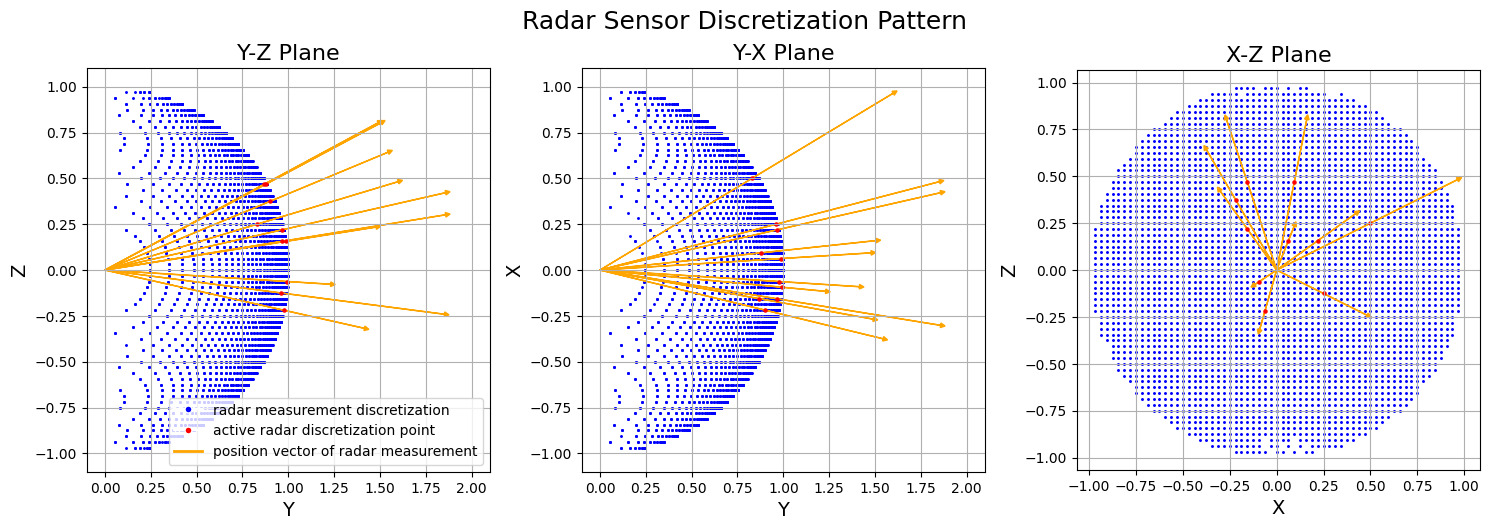


Some stats on TI from our data on a past project (PLR):
- 3189 unique X-Z pairs   ===  3189 unique azimuth-elevation pairs

**3189** can be approximately achieved with;
The circle has 64 points along diameter axis (where elevation==0). 
Using surface area formula $A=r^2\cdot\pi$ and plugging in $r=\frac{64}{2}$ gives $A=3'217.0$
This is approximately the same value.
--> Approximately 3'200 unique pairs are allowed.


- Azimuth: 

## Procedure:
Using the `radar_array` we now describe the concrete procedure for discretization:
1. Use spherical radar data to create unit-vectors in cartesian space.
2. Take X-Z Plane projection of unit-vectors and round to 1/64 precision in X and Z direction.
2. Adjust Y so that $r = 1 = \sqrt(x^2+y^2+z^2)$ holds. $y = |\sqrt(r^2 - x^2 - z^2)|$
3. Use this discretized unit-vector to calculate spherical coordinates [range, elevation, azimuth]. Remember that range will be 1!
4. Scale range back to original value using range-column from `radar_array`.
5. Discretize range and doppler according to precision.

In [73]:
radar_df = pd.DataFrame(columns=[
    "range", "elevation", "azimuth", "doppler", "vx_gt", "vy_gt", "vz_gt", "scan_counter", 
    "range_discretized", "elevation_discretized", "azimuth_discretized", "doppler_discretized"], 
    data=[])

radar_df[["range", "elevation", "azimuth", "doppler", "vx_gt", "vy_gt", "vz_gt", "scan_counter"]] = radar_array

ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].


/tmp/ipykernel_234742/1114413231.py:14: RuntimeWarning: invalid value encountered in sqrt
  radar_array_unit_vecs[:,1] = np.sqrt(1 - radar_array_unit_vecs[:,0]**2 - radar_array_unit_vecs[:,2]**2)


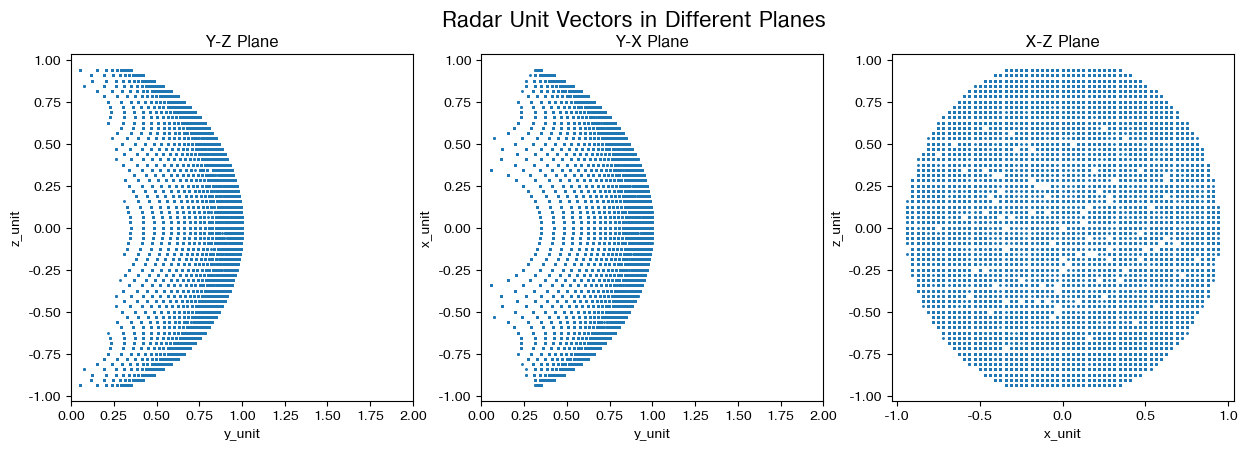

AssertionError: Conversion to spherical coordinates resulted in NaN values.

In [79]:
### 1. Create unit vectors ###
radar_array_unit_vecs = spherical_to_cartesian(np.hstack((
    np.ones((radar_array.shape[0], 1)), 
    radar_array[:,1:3]
    ))
)

### 2. Round columns x and z to nearest 1/64 ###
xz_precision = 2/64
radar_array_unit_vecs[:,0] = np.round(radar_array_unit_vecs[:,0]/xz_precision)*xz_precision
radar_array_unit_vecs[:,2] = np.round(radar_array_unit_vecs[:,2]/xz_precision)*xz_precision

### 3. Solve for y = |sqrt(1 - x^2 - z^2)| (since y is always positive) ###
radar_array_unit_vecs[:,1] = np.sqrt(1 - radar_array_unit_vecs[:,0]**2 - radar_array_unit_vecs[:,2]**2)

plot_radar_unit_vectors(radar_array_unit_vecs, 'cartesian')

### 4. Convert back to spherical coordinates ###
radar_unit_vecs_spherical_discretized = cartesian_to_spherical(radar_array_unit_vecs, 
                                                               angle_unit="degrees", 
                                                               convention="TI")

### 5. Scale range r back to its original value
radar_spherical_discretized = radar_unit_vecs_spherical_discretized.copy()
radar_spherical_discretized[:,0] *= radar_array[:,0]

### 6. Discretize range and doppler
doppler_precision = 0.04
range_precision = 0.214
# Range
radar_spherical_discretized[:,0] = np.round(radar_spherical_discretized[:,0]/range_precision)*range_precision
# Doppler
radar_doppler_discretized = radar_array[:,3].copy()
radar_doppler_discretized = np.round(radar_doppler_discretized/doppler_precision)*doppler_precision


### 7. Add discretized values to the dataframe
radar_df[["range_discretized", "elevation_discretized", "azimuth_discretized"]] = radar_spherical_discretized
radar_df["doppler_discretized"] = radar_doppler_discretized


# Unique elevation_discretized and azimuth_discretized pairs
unique_pairs = radar_df.groupby(["elevation_discretized", "azimuth_discretized"]).size()
print("Unique elevation-azimuth pairs (post-discretization): ", unique_pairs.shape[0])


## Plan B for discretization

ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].


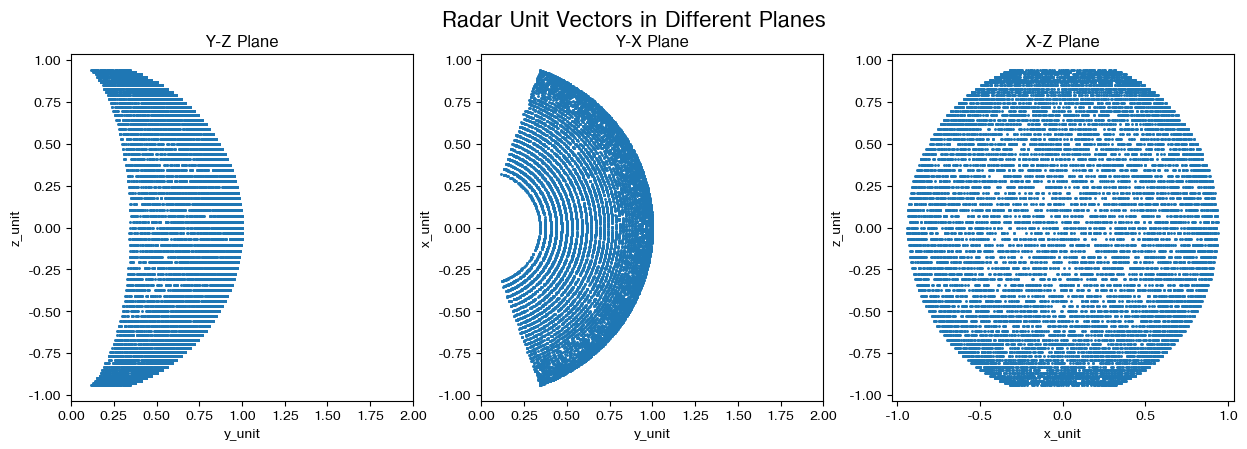

In [75]:
# Define the bins for discretization based on manual inputs
azimuth_bins = np.linspace(-70, 70, 64)
elevation_bins = np.linspace(-70, 70, 64)

azimuth_precision = 1.5
elevation_precision = 2
range_precision = 0.2
doppler_precision = 0.04

# Discretize each column of radar_array
azimuth_discretized = np.round(np.round(radar_array[:, 0] / azimuth_precision) * azimuth_precision, 2)
elevation_discretized = np.round(np.round(radar_array[:, 1] / elevation_precision) * elevation_precision, 2)
# Discretize range and doppler based on precision
range_discretized = np.round(radar_array[:, 2] / range_precision) * range_precision
doppler_discretized = np.round(radar_array[:, 3] / doppler_precision) * doppler_precision

# Combine the discretized columns into radar_array_discretized
radar_array_discretized = np.vstack((azimuth_discretized, elevation_discretized, range_discretized, doppler_discretized)).T
                                    #  radar_array[:,4:7])).T

plot_radar_unit_vectors(data=radar_array_discretized[:,0:3], type="spherical", angle_unit="degrees")


# Difference between continuous & discretized values
In this section we use the `radar_df` to; estimate ego-velocity using LSQ (or other loss) based on doppler-velocity projections.
Here we specifically we are interested in how accurate the ego-velocity is using the discretized values from `radar_df`, e.g. the columns `range_discretized`, `elevation_discretized`, `azimuth_discretized` and `doppler_discretized`.

## Procedure
1. For each scan:
2. use X radar-datapoints to estimate ego-velocity in cartesian coordinates. 
3. Compare to `[vx_gt, vy_gt, vz_gt]`. The element-wise difference is taken.
4. Provide different statistics combining these differences.

In [76]:
estimate = pd.DataFrame(columns=["vx_gt", "vy_gt", "vz_gt", "vx_est", "vy_est", "vz_est", "lsq_residual", "scan_counter"], data=[])

for scan_counter in range(n_scans):
    # Get the radar points for the current scan
    radar_points = radar_df[radar_df["scan_counter"] == scan_counter]

    # LSQ estimate of ego-velocity using each radar_point heading and doppler-shift
    H = np.zeros((radar_points.shape[0], 3))
    v_doppler = np.zeros((radar_points.shape[0], 1))

    # Unitary vector for each radar point
    radar_points_unit_vecs = spherical_to_cartesian(np.hstack((
        np.ones((radar_points.shape[0], 1)), radar_points[["elevation_discretized", "azimuth_discretized"]])),
        angle_unit="degrees",
        convention="TI")
    
    # Fill H and v_doppler
    H = radar_points_unit_vecs
    v_doppler = radar_points["doppler_discretized"].values.reshape(-1, 1)
    v_doppler = -v_doppler # Reverse sign as doppler is opposed to actual velocity

    # Solve for ego-velocity
    v_est, residual, _, _ = np.linalg.lstsq(H, v_doppler, rcond=None)

    # Append results
    res = {
        "vx_gt": radar_points["vx_gt"].values[0],
        "vy_gt": radar_points["vy_gt"].values[0],
        "vz_gt": radar_points["vz_gt"].values[0],
        "vx_est": v_est[0],
        "vy_est": v_est[1],
        "vz_est": v_est[2],
        "lsq_residual": residual[0],
        "scan_counter": scan_counter
    }
    df = pd.DataFrame(res)
    estimate = pd.concat([estimate, df], ignore_index=True)
    

ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].

/tmp/ipykernel_234742/1943849442.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  estimate = pd.concat([estimate, df], ignore_index=True)


ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].
ATTENTION: Using TI-convention for [range, elevation, azimuth] -> [x, y, z].

AssertionError: Azimuth and elevation angles must be in the range [-2, 2]. [[ 1.    -0.189  1.033]
 [ 1.     0.56   0.3  ]
 [ 1.    -0.948 -0.699]
 [ 1.    -0.716 -0.338]
 [ 1.     0.848  1.114]
 [ 1.     0.948  0.631]
 [ 1.     0.848 -0.287]
 [ 1.    -0.597 -0.982]
 [ 1.       nan    nan]
 [ 1.    -0.221  0.614]
 [ 1.    -0.802  0.57 ]
 [ 1.    -0.675 -0.749]
 [ 1.    -0.351  0.033]
 [ 1.    -0.285 -0.548]
 [ 1.     0.897 -0.253]]

In [55]:
estimate["v_mag_error"] = np.linalg.norm(estimate[["vx_gt", "vy_gt", "vz_gt"]].values - estimate[["vx_est", "vy_est", "vz_est"]].values, axis=1)
estimate.describe()


,vx_gt,vy_gt,vz_gt,vx_est,vy_est,vz_est,lsq_residual,v_mag_error
count,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000
mean,-0.042977,-0.016667,-0.001888,-0.043179,-0.015723,-0.001841,0.003394,0.012991
std,1.180308,0.289142,0.294826,1.179569,0.289310,0.295103,0.001808,0.006219
min,-1.997122,-0.497532,-0.498048,-1.999218,-0.506091,-0.513499,0.000708,0.001289
25%,-1.099927,-0.267806,-0.263036,-1.104306,-0.268939,-0.263849,0.002002,0.008773
50%,-0.103086,-0.025972,0.005291,-0.097506,-0.025673,0.005276,0.002936,0.012429
75%,0.944443,0.207062,0.239770,0.957729,0.208112,0.250376,0.004429,0.016090
max,1.997837,0.499924,0.492466,2.010493,0.503766,0.491689,0.010340,0.042620


In [56]:
# MSE of LSQ-Estimate
norm = np.linalg.norm(estimate[["vx_gt", "vy_gt", "vz_gt"]].values - estimate[["vx_est", "vy_est", "vz_est"]].values, axis=1)
RMSE = np.sqrt(np.mean(np.linalg.norm(
    estimate[["vx_gt", "vy_gt", "vz_gt"]].values - estimate[["vx_est", "vy_est", "vz_est"]].values, axis=1)
    ))

In [57]:
RMSE

np.float64(0.11397801317522835)